In [11]:
from pathlib import Path 
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
# Import the DataManager class for data preprocessing
from tstoolkit.data_preprocess import DataManager

In [3]:
# Define the path to the time series data file
data_path = Path("../data/example_data.hd5")

# Create an instance of a data manager (DataManager) with the specified data file path
data_manager = DataManager(data_path)

# Load the time series data from the specified data file
data = data_manager.load_data()

data.head()

,PropertyID,DateTime,Value
0,300468,2020-01-01 00:00:00,65.992325
1,300468,2020-01-01 00:00:30,59.085239
2,300468,2020-01-01 00:01:00,63.399876
3,300468,2020-01-01 00:01:30,74.437500
4,300468,2020-01-01 00:02:00,60.391750


In [4]:

# Preprocess the time series data
data = data_manager.preprocess_data(data)

# Fill gaps or missing values in the time series data using linear interpolation
data = data_manager.interpolate_nulls(data, interpolation_method="linear")

data.set_index("DateTime",inplace=True)

# View top 5 rows of the processed data
data.head()

,300468,300498,305256,315036,340686,341124,341550
DateTime,,,,,,,
2020-01-01 00:00:00,65.992325,2036.845581,58.777546,114.388023,1.737929,5.342316,1.386370
2020-01-01 00:00:30,59.085239,2036.812866,67.127098,114.341003,1.691197,5.378604,1.403499
2020-01-01 00:01:00,63.399876,2036.780151,72.960365,114.293983,1.861186,5.308666,1.416289
2020-01-01 00:01:30,74.437500,2036.780334,71.723625,114.207180,1.830390,5.459568,1.512679
2020-01-01 00:02:00,60.391750,2036.780518,70.489014,114.120377,1.729635,5.588947,1.548172


In [ ]:
def min_max_scaling_df(df):
    min_vals = df.min()
    max_vals = df.max()
    scaled_df = (df - min_vals) / (max_vals - min_vals)
    return scaled_df

def inverse_min_max_scaling_df(scaled_df, min_vals, max_vals):
    original_df = (scaled_df * (max_vals - min_vals)) + min_vals
    return original_df

In [22]:
property_columns = ['300468', '300498', '305256', '315036', '340686', '341124','341550']

for col in property_columns:
    series = data[col]
    result = adfuller(series)
    print(f"Sensor Key: {col} ADF Statistic: %f" % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


Sensor Key: 300468 ADF Statistic: -28.920039
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Sensor Key: 300498 ADF Statistic: -2.601709
p-value: 0.092644
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Sensor Key: 305256 ADF Statistic: -6.684790
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Sensor Key: 315036 ADF Statistic: -4.490974
p-value: 0.000204
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Sensor Key: 340686 ADF Statistic: -2.572745
p-value: 0.098762
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Sensor Key: 341124 ADF Statistic: -2.759356
p-value: 0.064318
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Sensor Key: 341550 ADF Statistic: -3.384921
p-value: 0.011484
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Test RMSE: 0.119


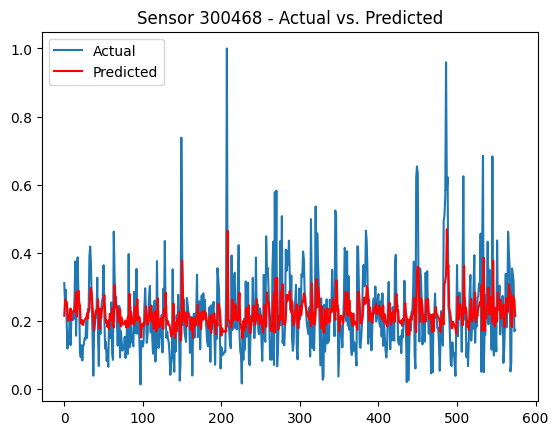

Test RMSE: 0.011


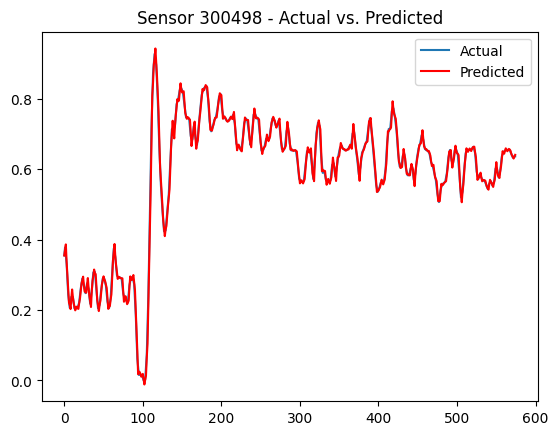

Test RMSE: 0.124


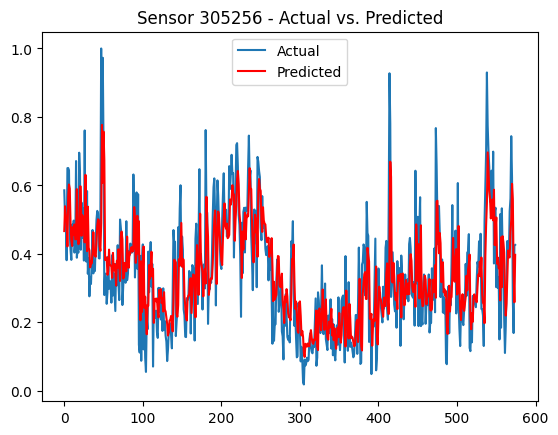

Test RMSE: 0.032


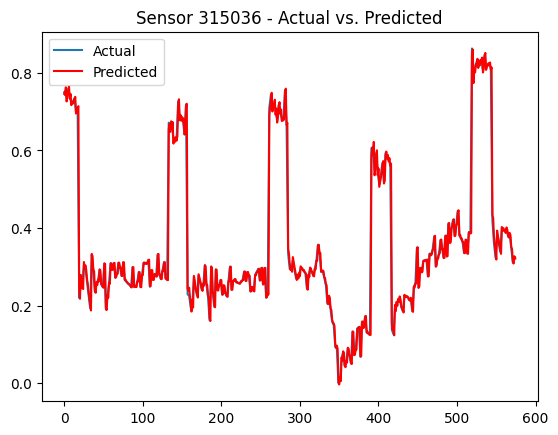

Test RMSE: 0.030


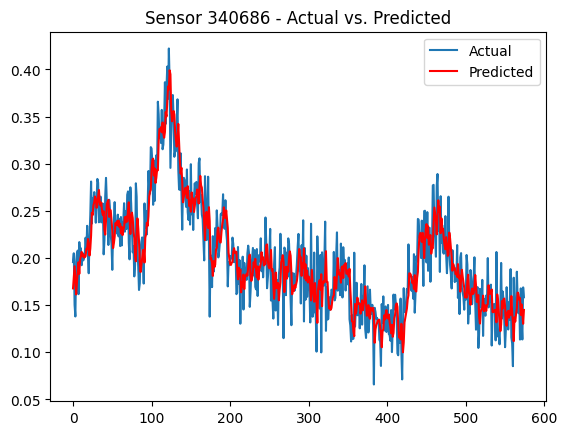

Test RMSE: 0.004


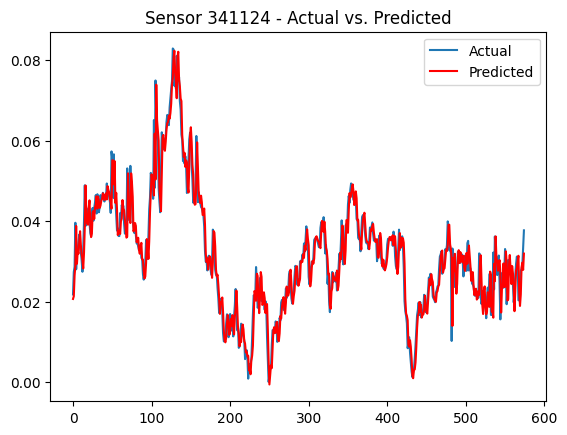

Test RMSE: 0.033


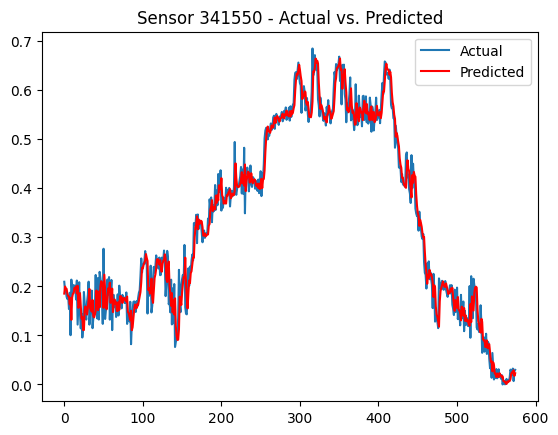

In [24]:
property_columns = ['300468', '300498', '305256', '315036', '340686', '341124','341550']

for col in property_columns:
    series = data[col]

    X = min_max_scaling_df(series.values)
    size = int(len(X) * 0.80)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(2,1,2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts

    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.plot(test, label='Actual')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title(f"Sensor {col} - Actual vs. Predicted")
    plt.legend()
    plt.show()
